<a href="https://colab.research.google.com/github/Gamila-Elfayoumi/Neural-Networks/blob/main/weather_project_LSTM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# ============================
# Data Loading & Preprocessing
# ============================

# Load the weather dataset. (Ensure the file path is correct.)
data = pd.read_csv('/content/weatherHistory.csv')

In [5]:
# Display an initial preview of the data and basic info.
print("Initial Data Preview:")
print(data.head())
print("\nData Info:")
print(data.info())

Initial Data Preview:
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0  

In [6]:
# Convert the 'Formatted Date' column to datetime format (with UTC) and sort the data by date.
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data.sort_values('Formatted Date', inplace=True)

In [7]:
# Select the numerical features that are relevant for modeling:
# Temperature (C), Humidity, Wind Speed (km/h), Visibility (km), and Pressure (millibars).
cols = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
data = data[cols]

# Handle any missing values by forward-filling then backward-filling.
data = data.ffill().bfill()

print("\nData Info After Preprocessing:")
print(data.info())


Data Info After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
Index: 96453 entries, 2880 to 89732
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature (C)       96453 non-null  float64
 1   Humidity              96453 non-null  float64
 2   Wind Speed (km/h)     96453 non-null  float64
 3   Visibility (km)       96453 non-null  float64
 4   Pressure (millibars)  96453 non-null  float64
dtypes: float64(5)
memory usage: 4.4 MB
None


In [8]:
# Verify that a temperature column exists (case-insensitive search).
temp_col = None
for col in data.columns:
    if 'temp' in col.lower():
        temp_col = col
        break
if temp_col is None:
    raise ValueError("No temperature column found in the dataset.")

In [9]:
# ============================
# Data Normalization & Sequence Creation
# ============================

# Normalize the data between 0 and 1 using MinMaxScaler.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_array = data.values.astype(np.float32)
data_scaled = scaler.fit_transform(data_array)

In [10]:
def create_sequences(data, seq_length, target_col_idx=0):
    """
    Create time-series sequences for forecasting.

    For each position in the data, this function extracts a sequence of a fixed length (seq_length)
    and uses the next value in the target column (e.g., temperature) as the prediction target.

    Parameters:
    - data: numpy array of shape (num_samples, num_features)
    - seq_length: length of the input sequence (window size)
    - target_col_idx: index of the target column in the data (default is 0 for Temperature)

    Returns:
    - xs: array of input sequences
    - ys: array of target values (next time-step)
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, target_col_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length and create input (X) and output (y) arrays.
seq_length = 10
X, y = create_sequences(data_scaled, seq_length, target_col_idx=0)

# Split the sequences into training (80%) and testing (20%) sets.
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test   = X[train_size:], y[train_size:]

In [11]:
# ============================
# PyTorch Dataset & DataLoader Creation
# ============================
import torch
from torch.utils.data import DataLoader, Dataset

class TimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset for time-series data.

    It converts the input sequences and targets into torch tensors.
    """
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # shape: (samples, seq_length, num_features)
        self.y = torch.from_numpy(y).unsqueeze(-1)  # shape: (samples, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
# Set batch size and create DataLoaders for training and testing.
batch_size = 128
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset  = TimeSeriesDataset(X_test, y_test)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:

# ============================
# Define the LSTM Model
# ============================
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
        """
        LSTM model for time-series forecasting.

        Parameters:
        - input_size: number of features per time step.
        - hidden_size: number of features in hidden state.
        - num_layers: number of stacked LSTM layers.
        - output_size: number of outputs (e.g., 1 for temperature prediction).
        - dropout: dropout rate to prevent overfitting.
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        # Define a fully connected layer to map hidden state output to final prediction.
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass for LSTM.

        Parameters:
        - x: input tensor of shape (batch, seq_length, input_size)

        Returns:
        - output: tensor of shape (batch, output_size)
        """
        # Initialize hidden and cell states with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass input through LSTM layers.
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch, seq_length, hidden_size)
        # Use the output from the last time step.
        out = out[:, -1, :]
        # Pass through the fully connected layer to obtain final output.
        out = self.fc(out)
        return out


In [14]:
# ============================
# Training and Evaluation Functions
# ============================
def compute_epoch_accuracy(model, loader, device, tolerance=0.1):
    """
    Compute accuracy: percentage of predictions within a given tolerance.

    Parameters:
    - model: the trained model
    - loader: DataLoader for dataset to evaluate
    - device: CPU or GPU device
    - tolerance: allowed difference between prediction and actual value

    Returns:
    - Accuracy as a percentage.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            correct += (torch.abs(outputs - y_batch) < tolerance).sum().item()
            total += y_batch.numel()
    return (correct / total) * 100

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer,
                       num_epochs, device, tolerance=0.1, early_stopping_patience=10):
    """
    Train the LSTM model and evaluate its performance.

    Parameters:
    - model: LSTM model to train.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for test data.
    - criterion: loss function (e.g., MSELoss).
    - optimizer: optimization algorithm (e.g., Adam).
    - num_epochs: number of training epochs.
    - device: computation device.
    - tolerance: tolerance for accuracy measurement.
    - early_stopping_patience: epochs to wait without improvement before stopping.

    Returns:
    - Lists of train losses, train accuracies, test losses, and test accuracies.
    """
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_acc = compute_epoch_accuracy(model, train_loader, device, tolerance)
        train_accuracies.append(train_acc)

        # Evaluation loop on test set.
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)

        epoch_test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        test_acc = compute_epoch_accuracy(model, test_loader, device, tolerance)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Test Loss: {epoch_test_loss:.4f}, "
              f"Test Acc: {test_acc:.2f}%")

        # Early stopping check.
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_lstm_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    return train_losses, train_accuracies, test_losses, test_accuracies


In [15]:
def plot_metrics(train_metric, test_metric, ylabel, title, num_epochs):
    """
    Plot training and testing metrics (loss or accuracy) over epochs.
    """
    epochs = range(1, num_epochs+1)
    plt.figure()
    plt.plot(epochs, train_metric, label='Train')
    plt.plot(epochs, test_metric, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


Training LSTM Model with Optimized Parameters...
Epoch 1/20: Train Loss: 0.1568, Train Acc: 44.76%, Test Loss: 0.0192, Test Acc: 47.29%
Epoch 2/20: Train Loss: 0.0197, Train Acc: 55.59%, Test Loss: 0.0120, Test Acc: 62.43%
Epoch 3/20: Train Loss: 0.0114, Train Acc: 74.73%, Test Loss: 0.0067, Test Acc: 77.13%
Epoch 4/20: Train Loss: 0.0063, Train Acc: 86.68%, Test Loss: 0.0038, Test Acc: 89.37%
Epoch 5/20: Train Loss: 0.0047, Train Acc: 91.34%, Test Loss: 0.0032, Test Acc: 94.09%
Epoch 6/20: Train Loss: 0.0040, Train Acc: 93.70%, Test Loss: 0.0025, Test Acc: 96.23%
Epoch 7/20: Train Loss: 0.0034, Train Acc: 95.51%, Test Loss: 0.0021, Test Acc: 97.35%
Epoch 8/20: Train Loss: 0.0028, Train Acc: 97.00%, Test Loss: 0.0017, Test Acc: 98.08%
Epoch 9/20: Train Loss: 0.0024, Train Acc: 97.61%, Test Loss: 0.0015, Test Acc: 98.30%
Epoch 10/20: Train Loss: 0.0021, Train Acc: 98.30%, Test Loss: 0.0014, Test Acc: 98.74%
Epoch 11/20: Train Loss: 0.0019, Train Acc: 98.43%, Test Loss: 0.0013, Test Acc

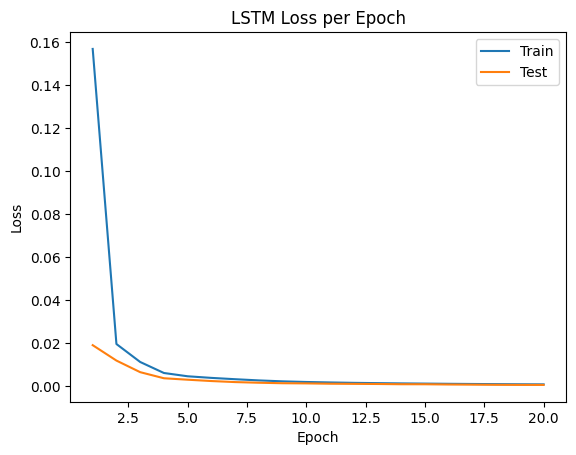

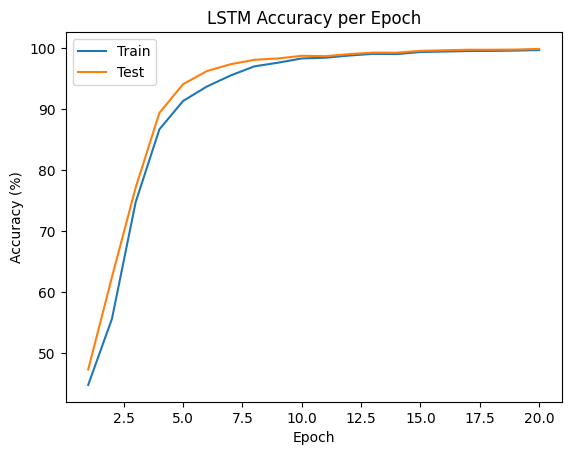

In [16]:
# ============================
# Model Training with Optimized Parameters
# ============================
# Set hyperparameters with modifications for potentially better accuracy.
input_size = 5       # Number of features.
hidden_size = 32     # Increased hidden state dimension for improved capacity.
num_layers = 2       # Using 2 LSTM layers.
output_size = 1      # Predict temperature.
num_epochs = 20      # Increase number of epochs.
learning_rate = 0.00005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nTraining LSTM Model with Optimized Parameters...")

# Instantiate the LSTM model.
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Train and evaluate the LSTM model.
lstm_train_losses, lstm_train_acc, lstm_test_losses, lstm_test_acc = train_and_evaluate(
    lstm_model, train_loader, test_loader, criterion, optimizer,
    num_epochs, device, tolerance=0.1, early_stopping_patience=10
)

# Plot loss and accuracy metrics.
plot_metrics(lstm_train_losses, lstm_test_losses, ylabel='Loss', title='LSTM Loss per Epoch', num_epochs=num_epochs)
plot_metrics(lstm_train_acc, lstm_test_acc, ylabel='Accuracy (%)', title='LSTM Accuracy per Epoch', num_epochs=num_epochs)

In [17]:
# ============================
# Saving and Loading the Model
# ============================
from pathlib import Path

# Create a directory to save the model if not existing.
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "weather_lstm_model_optimized.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the optimized LSTM model.
torch.save(lstm_model.state_dict(), MODEL_SAVE_PATH)
print(f"Optimized LSTM model saved to: {MODEL_SAVE_PATH}")

# Reload the model to verify save-load functionality.
loaded_lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.1).to(device)
loaded_lstm_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_lstm_model.eval()


Optimized LSTM model saved to: models/weather_lstm_model_optimized.pth


LSTMModel(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [28]:

# ============================
# Model Evaluation on Test Data
# ============================
def evaluate_model(model, loader, criterion, device):
    """
    Evaluate the model performance on a given dataset.

    Parameters:
    - model: trained model.
    - loader: DataLoader for evaluation data.
    - criterion: loss function.
    - device: computation device.

    Returns:
    - Average loss over the dataset.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

# Evaluate the loaded LSTM model on the test set.
test_loss = evaluate_model(loaded_lstm_model, test_loader, criterion, device)
test_acc = compute_epoch_accuracy(loaded_lstm_model, test_loader, device, tolerance=0.1)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Loss: 0.0007
Final Test Accuracy: 99.87%


In [33]:
def evaluate_model(model, X_test, y_test):
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test MAE: {mae:.4f}")

def make_predictions(model, X):
    predictions = model.predict(X)
    return predictions

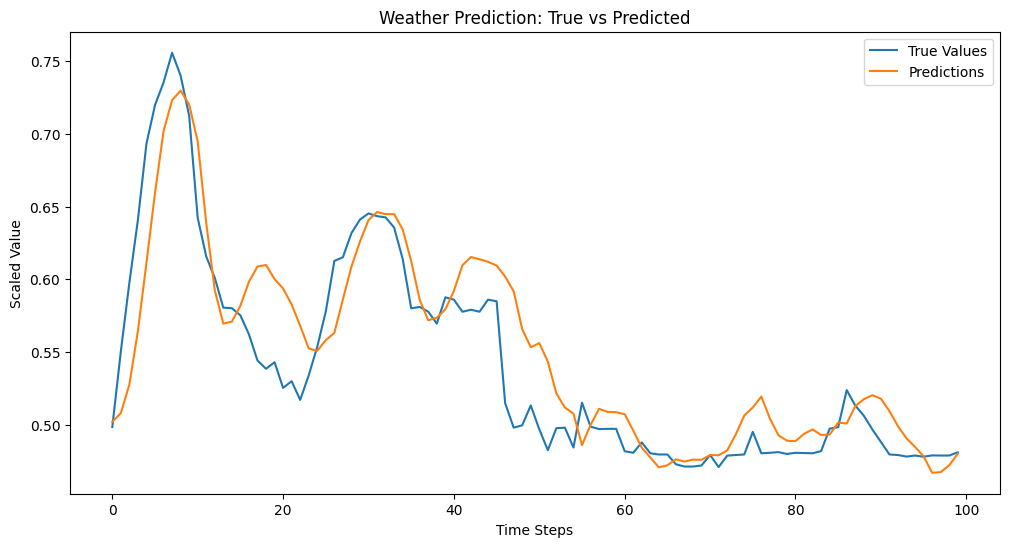

In [38]:
import matplotlib.pyplot as plt
import torch # Import torch

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values')
    plt.plot(y_pred, label='Predictions')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

# Make predictions on the test set using the PyTorch model
# Ensure the model is in evaluation mode and data is on the correct device
loaded_lstm_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is defined
X_test_tensor = torch.from_numpy(X_test).to(device) # Convert X_test to tensor and move to device

with torch.no_grad():
    predictions_tensor = loaded_lstm_model(X_test_tensor)

# Move predictions back to CPU and convert to numpy for plotting
predictions = predictions_tensor.cpu().numpy()

# Plot some predictions (need to ensure y_test is also in a format suitable for plotting)
# y_test is already a numpy array, so it's fine
plot_results(y_test[:100], predictions[:100], 'Weather Prediction: True vs Predicted')